In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths

storage = paths.storage.Storage("_toy_retis.nc", "r")

In [2]:
len(storage.samplesets)

10001

In [3]:
retis = storage.transitions.load(0)

In [4]:
%%time
storage.samples.cache_all()

CPU times: user 3.43 s, sys: 224 ms, total: 3.65 s
Wall time: 3.8 s


### Defining labels

Everything is actually done in terms of ensembles. We can map the ensembles to any labels. In our case, we use the initial replica ID associated with the ensemble. We use this as both the numeric and string label.

In [5]:
sset0 = storage.samplesets[0]
numeric_labels = { s.ensemble : s.replica for s in sset0}
string_labels = { s.ensemble : str(s.replica) for s in sset0 }
numeric_to_string = { numeric_labels[e] : string_labels[e] for e in numeric_labels.keys()}

## Trace of ensemble visited by a replica

In the plot below, you'll see we set the labels on the axis as sset0[e].replica, so we use the replica ID associated with the ensemble in the first timestep.

In [6]:
%%time
trace_1 = paths.trace_ensembles_for_replica(0, storage)

CPU times: user 3min 8s, sys: 1.82 s, total: 3min 10s
Wall time: 3min 12s


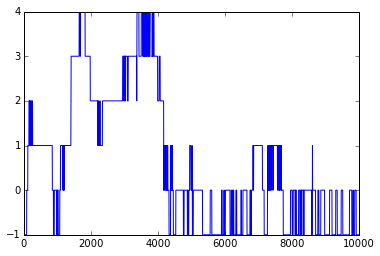

In [7]:
plt.plot([numeric_labels[e] for e in trace_1])

### Replica flow

In [8]:
repx_net = paths.ReplicaNetwork(storage=storage)

In [9]:
flow = repx_net.flow(bottom=retis.minus_ensemble, top=retis.ensembles[-1])
flow_num = {numeric_labels[k] : flow[k] for k in flow.keys()}
sorted_vals = []
for k in sorted(flow_num.keys()):
    sorted_vals.append(flow_num[k])

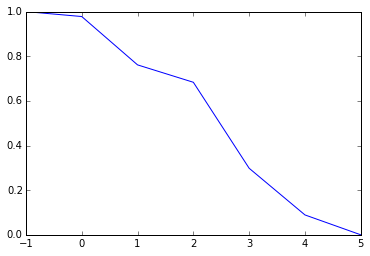

In [10]:
plt.plot(sorted(flow_num.keys()), sorted_vals)

### Trips

Now we calculate "up" trips, "down" trips, and round-trips.

In [11]:
repx_net.trips(bottom=retis.minus_ensemble, top=retis.ensembles[-1])

{'down': [2028], 'round': [8730], 'up': [6921, 6702, 4127]}

### Transition matrix

The transition matrix is the (unsymmetrized) matrix of the transition probabilities. By default, it automatically sets its order from the Cuthill-McKee reverse ordering algorithm.

In [12]:
repx_net.transition_matrix()

,-1,0,1,2,3,4,5
-1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0
0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,0,0.291581,0.000000,0.000000,0.000000,0.000000,0
2,0,0.000000,0.232323,0.000000,0.000000,0.000000,0
3,0,0.000000,0.000000,0.187225,0.000000,0.000000,0
4,0,0.000000,0.000000,0.000000,0.253012,0.000000,0
5,0,0.000000,0.000000,0.000000,0.000000,0.549107,0


If you would like to set a different order, that can be done by providing a list of the ensembles in whatever order you choose:

In [13]:
order = [retis.ensembles[5], retis.ensembles[3], retis.ensembles[1], 
         retis.minus_ensemble, retis.ensembles[4], retis.ensembles[2], 
         retis.ensembles[0]]
repx_net.transition_matrix(index_order=order)

,5,3,1,-1,4,2,0
5,0,0.000000,0.000000,0,0.549107,0.000000,0.000000
3,0,0.000000,0.000000,0,0.000000,0.187225,0.000000
1,0,0.000000,0.000000,0,0.000000,0.000000,0.291581
-1,0,0.000000,0.000000,0,0.000000,0.000000,0.000000
4,0,0.253012,0.000000,0,0.000000,0.000000,0.000000
2,0,0.000000,0.232323,0,0.000000,0.000000,0.000000
0,0,0.000000,0.000000,1,0.000000,0.000000,0.000000


### Mixing matrix

Same as the transition matrix $T$, but $\frac{1}{2}(T+T^T)$.

In [14]:
repx_net.mixing_matrix()

,-1,0,1,2,3,4,5
-1,0.0,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.5,0.000000,0.145791,0.000000,0.000000,0.000000,0.000000
1,0.0,0.145791,0.000000,0.116162,0.000000,0.000000,0.000000
2,0.0,0.000000,0.116162,0.000000,0.093612,0.000000,0.000000
3,0.0,0.000000,0.000000,0.093612,0.000000,0.126506,0.000000
4,0.0,0.000000,0.000000,0.000000,0.126506,0.000000,0.274554
5,0.0,0.000000,0.000000,0.000000,0.000000,0.274554,0.000000


### Making a pretty picture

In [15]:
repxG = paths.ReplicaNetworkGraph(repx_net)

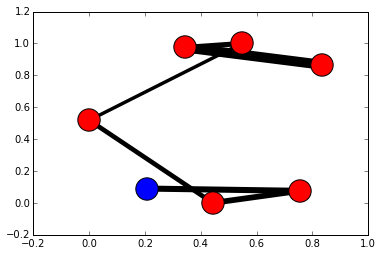

In [16]:
# draw('graphviz') gives better results, but requires pygraphviz
repxG.draw('spring')

Blue is a minus interface, red is a normal interface. Multiple state outer interfaces (not in this example) would be green.

### Alternate way of calculating transitions

There's another, perhaps better, way to calculate transitions. This does double count, but doesn't care if the how the transition happened (only that it did).

In [17]:
transitions = repx_net.transitions_from_traces(storage)

In [18]:
for (k1, k2)  in transitions.keys():
    print numeric_labels[k1], numeric_labels[k2], transitions[(k1, k2)]

4 3 126
4 5 246
3 2 85
2 1 115
0 1 142
3 4 126
0 -1 149
-1 0 149
2 3 85
1 2 115
1 0 142
5 4 246


In [19]:
for (k1, k2) in repx_net.analysis['n_accepted'].keys():
        print numeric_labels[k1], numeric_labels[k2], repx_net.analysis['n_accepted'][(k1, k2)]

0 -1 149
5 4 246
2 1 115
4 3 126
1 0 142
3 2 85
